# Pytorch

## Preprocessing the data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv('cleaned_data/aalborg_data.csv')
df.head()

,angle,rpm,speed_x,speed_y,track_position,acceleration,brake,steer
0,0.227636,942,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
1,0.227636,1100,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
2,0.227636,1263,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
3,0.227636,1432,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716
4,0.227636,1605,-0.092262,0.026604,-0.334175,1.0,0.0,0.466716


In [4]:
# Select relevant columns for features and target
# features = df[['angle', 'speed_x', 'speed_y', 'track_position']]
features = df[['angle', 'rpm', 'speed_x', 'speed_y', 'track_position']]
targets = df[['acceleration', 'brake', 'steer']]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)


## Create the model

In [5]:
import torch.nn as nn

class CarControlModel(nn.Module):
    def __init__(self):
        super(CarControlModel, self).__init__()
        self.fc1 = nn.Linear(5, 64)  # 4 input features
        # self.fc1 = nn.Linear(5, 64)  # 5 input features
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)  # 3 output actions

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CarControlModel().to(device)


In [6]:
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import r2_score


# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
batch_size = 64

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize lists to store loss values
train_losses = []
test_losses = []
test_r2_scores = []


for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()

    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

        test_r2 = r2_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_r2_scores.append(test_r2)


    # Print loss and R² for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss.item():.6f}, Test R²: {test_r2:.6f}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.033218, Test Loss: 0.025710, Test R²: 0.608545
Epoch [2/100], Train Loss: 0.023953, Test Loss: 0.024568, Test R²: 0.622836
Epoch [3/100], Train Loss: 0.022401, Test Loss: 0.021850, Test R²: 0.641386
Epoch [4/100], Train Loss: 0.020810, Test Loss: 0.022742, Test R²: 0.616904
Epoch [5/100], Train Loss: 0.019257, Test Loss: 0.019956, Test R²: 0.660622
Epoch [6/100], Train Loss: 0.019515, Test Loss: 0.019438, Test R²: 0.669892
Epoch [7/100], Train Loss: 0.018084, Test Loss: 0.018447, Test R²: 0.682585
Epoch [8/100], Train Loss: 0.017057, Test Loss: 0.019874, Test R²: 0.677593
Epoch [9/100], Train Loss: 0.016776, Test Loss: 0.016908, Test R²: 0.687328
Epoch [10/100], Train Loss: 0.016331, Test Loss: 0.015783, Test R²: 0.709248
Epoch [11/100], Train Loss: 0.015650, Test Loss: 0.016989, Test R²: 0.701869
Epoch [12/100], Train Loss: 0.015883, Test Loss: 0.014057, Test R²: 0.725027
Epoch [13/100], Train Loss: 0.015291, Test Loss: 0.014537, Test R²: 0.728391
Epoch [1

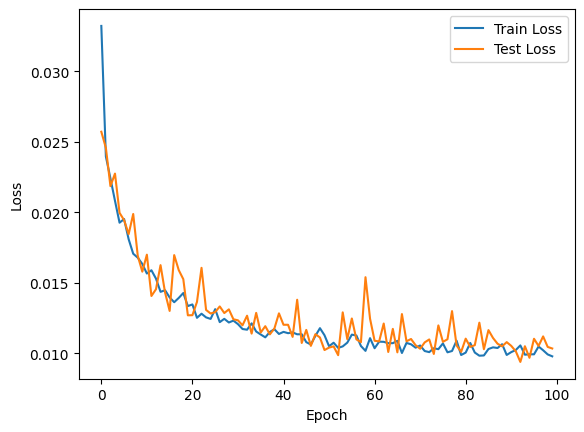

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')	
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

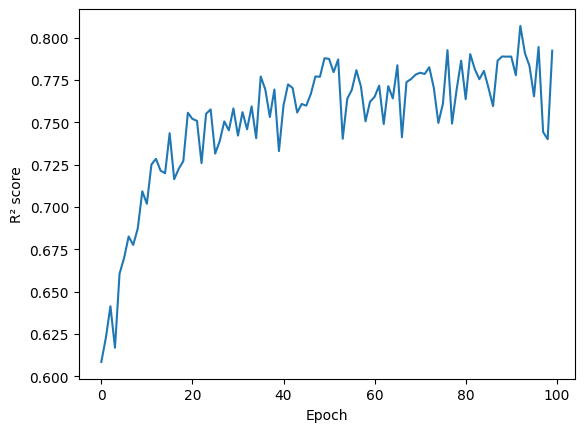

In [8]:
# plot the R² score
plt.plot(test_r2_scores)
plt.xlabel('Epoch')
plt.ylabel('R² score')
plt.show()

## Calculate the accuracy

In [ ]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        predictions = model(X_test).cpu().numpy()  # Make predictions and move to CPU
        targets = y_test.cpu().numpy()  # Move targets to CPU
    
    # Calculate evaluation metrics
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'R-squared (R²): {r2:.4f}')
    
    return mse, mae, r2

mse, mae, r2 = evaluate_model(model, X_test, y_test)


## Save the model

In [ ]:
# Save the model
torch.save(model.state_dict(), 'models/car_control_model.pth')

In [ ]:
# load the model
model_loaded = CarControlModel().to(device)
model_loaded.load_state_dict(torch.load('models/car_control_model.pth'))


In [ ]:
# Save scaler
import pickle

with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    

## Make predictions

In [ ]:
# Make predictions

def predict(model, scaler, X):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        X = torch.tensor(scaler.transform(X), dtype=torch.float32).to(device)
        predictions = model(X).cpu().numpy()  # Make predictions and move to CPU
    return predictions

# Example input from the test set
X_example = X_test[:5]
y_example = y_test[:5]

# Make predictions
predictions = predict(model_loaded, scaler, X_example)
print('Predictions:')
print(predictions)
print('\nTrue values:')
print(y_example)
